In [1]:
### Imports

from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import seaborn as sns
import scipy

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras import metrics # https://keras.io/metrics/ - ver a parte de custom metrics
from keras.callbacks import History 
from keras.utils.vis_utils import plot_model

import tensorflow as tf

### Funções minhas

# Adicionando ruído às imagens
def add_noise(sigma, bw_img):
    """Adiciona ruído a uma imagem em escala de cinza com valores entre 0 e 1"""
    sh = bw_img.shape
    noise = np.random.normal(0, sigma, sh)
    newgray = bw_img + noise
    return newgray

def plot_original_reconstructed(pred, numero):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(faces[numero].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(newfaces[numero].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(pred[numero].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

def plot_compare(idx, original, noisy, predicted):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(original[idx].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(noisy[idx].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(predicted[idx].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

## Funcao custo customizada: SSIM

def ssim_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

Using TensorFlow backend.


In [2]:
### Base de dados

db = fetch_lfw_people()

faces = db['data']
total_imagens = len(faces)
faces_matrix = np.empty((total_imagens, 60, 44))

for i in range(total_imagens):
    faces_matrix[i] = faces[i].reshape(62, 47)[1:61, 1:45]

# Normalizando imagens
faces_matrix = faces_matrix/np.amax(faces_matrix)

# Adicionando ruído de sd = 0.05
del faces
faces = faces_matrix
noisyfaces = add_noise(0.05, faces)


In [3]:
## Train and test split

treino, teste, noisytrain, noisytest = train_test_split(faces_matrix, noisyfaces, test_size = 0.2, random_state = 1)

noisytrain = noisytrain.reshape(-1, 60, 44, 1)
treino = treino.reshape(-1, 60, 44, 1)

noisytest = noisytest.reshape(-1, 60, 44, 1)
teste = teste.reshape(-1, 60, 44, 1)

In [4]:
### Escolhendo métricas que serão monitoradas

# Funções custo e métricas podem ser utilizadas como métricas
metricas = [
            'mean_squared_error', 
            'mean_absolute_error',
            'binary_crossentropy', 
            'accuracy' 
            ] 

# First autoencoder: MSE cost, 30 epochs

In [5]:
def make_autoencoder():
  # encoding
  inputs = Input(shape=(60, 44, 1)) 
  x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
  x = MaxPooling2D(pool_size = (4, 4), padding = 'same')(x)
  x = Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
  encoded = MaxPooling2D(padding = 'same')(x)

  # decoding
  x = UpSampling2D(size = (4, 4))(x)
  decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 

  # autoencoder compilation
  autoencoder = Model(inputs, decoded)
  autoencoder.compile(optimizer = 'adam', loss = "mse", metrics = metricas)
  return autoencoder

autoencoder_mse = make_autoencoder()
history_mse = History()

autoencoder_mse.fit(noisytrain, treino, epochs=20, batch_size=128, callbacks=[history_mse], validation_split = 0.1)

Train on 9527 samples, validate on 1059 samples
Epoch 1/20
9527/9527 [==============================] - 15s 2ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1174 - binary_crossentropy: 0.6732 - accuracy: 3.9958e-05 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0686 - val_binary_crossentropy: 0.6442 - val_accuracy: 5.0791e-05
Epoch 2/20
9527/9527 [==============================] - 15s 2ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0601 - binary_crossentropy: 0.6395 - accuracy: 4.8785e-05 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0527 - val_binary_crossentropy: 0.6362 - val_accuracy: 5.1864e-05
Epoch 3/20
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0499 - binary_crossentropy: 0.6346 - accuracy: 4.8904e-05 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolut

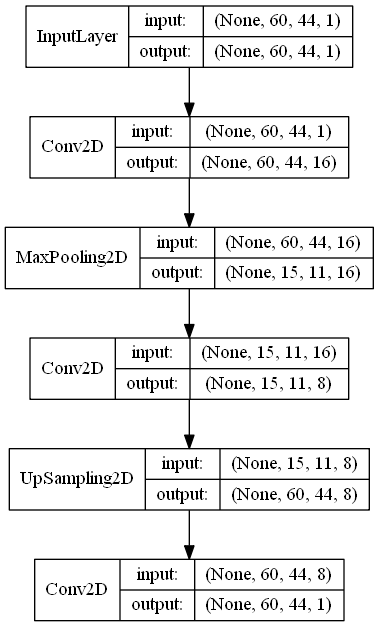

In [6]:
plot_model(autoencoder_mse, show_shapes=True, show_layer_names=False)

In [9]:
# after running, save keras model with
autoencoder_mse.save('30iter_MSE_val20')

In [10]:
# and save history with
import pickle
pickle.dump(history_mse, open( "save_historias_30iter_mse_val20", "wb" ) )

In [7]:
pred_train = autoencoder_mse.predict(noisytrain) # in sample
pred_test = autoencoder_mse.predict(noisytest) # out of sample

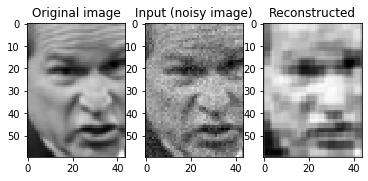

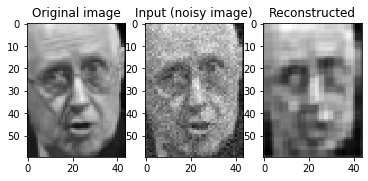

In [8]:
plot_compare(25, teste, noisytest, pred_test) # out of sample prediction

plot_compare(15, treino, noisytrain, pred_train) # in sample prediction - should be better

In [1]:
start = 1
finish = 40

y1 = history_mse.history['loss'][start:finish]
y2 = history_mse.history['val_loss'][start:finish]
x = range(start, finish)
sns.lineplot(x, y1).legend('loss')
sns.lineplot(x, y2).legend('val_loss')

NameError: name 'history_mse' is not defined

## Calculating MSE(1), in-sample and out-of-sample

In [31]:
mse_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    mse_list_treino[i] = np.mean((pred_train[i] - noisytrain[i])**2)
    
mse_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    mse_list_teste[i] = np.mean((pred_test[i] - noisytest[i])**2)


Text(0.5, 1.0, 'MSE(1) distribution')

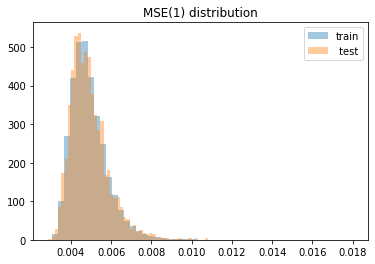

In [32]:
sns.distplot(mse_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(mse_list_teste, label = ' test', norm_hist=True, kde=False)
plt.legend()
plt.title("MSE(1) distribution")

#plt.xlim(0.0015, 0.0040)

## Calculating MSE(2), in-sample and out-of-sample

In [29]:
mse_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    mse_list_treino[i] = np.mean((pred_train[i] - treino[i])**2)
    
mse_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    mse_list_teste[i] = np.mean((pred_test[i] - teste[i])**2)


Text(0.5, 1.0, 'MSE(2) distribution')

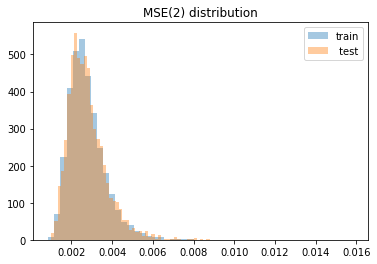

In [30]:
sns.distplot(mse_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(mse_list_teste, label = ' test', norm_hist=True, kde=False)
plt.legend()
plt.title("MSE(2) distribution")

#plt.xlim(0.0015, 0.0040)

## Calculating SSIM(1), in-sample and out-of-sample

In [13]:
from skimage import measure

In [33]:
ssim_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    ssim_list_treino[i] = measure.compare_ssim(noisytrain[i,:,:,0], pred_train[i,:,:,0])
    
ssim_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    ssim_list_teste[i] = measure.compare_ssim(noisytest[i,:,:,0], pred_test[i,:,:,0])

Text(0.5, 1.0, 'SSIM(1) distribution - train/test')

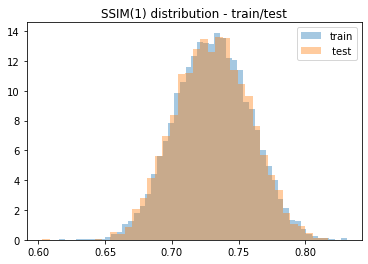

In [35]:
sns.distplot(ssim_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(ssim_list_teste, label = ' test', norm_hist=True, kde=False)
plt.legend()
plt.title("SSIM(1) distribution - train/test")

## Calculating SSIM(2), in-sample and out-of-sample

In [13]:
from skimage import measure

In [36]:
ssim_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    ssim_list_treino[i] = measure.compare_ssim(treino[i,:,:,0], pred_train[i,:,:,0])
    
ssim_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    ssim_list_teste[i] = measure.compare_ssim(teste[i,:,:,0], pred_test[i,:,:,0])

Text(0.5, 1.0, 'SSIM(2) distribution - train/test')

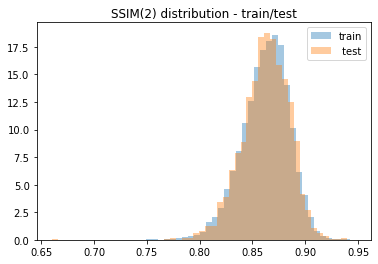

In [37]:
sns.distplot(ssim_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(ssim_list_teste, label = ' test', norm_hist=True, kde=False)
plt.legend()
plt.title("SSIM(2) distribution - train/test")

# Second autoencoder: SSIM cost, 30 epochs

In [39]:
def make_autoencoder():
  # encoding
  inputs = Input(shape=(60, 44, 1)) 
  x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
  x = MaxPooling2D(pool_size = (4, 4), padding = 'same')(x)
  x = Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
  encoded = MaxPooling2D(padding = 'same')(x)

  # decoding
  x = UpSampling2D(size = (4, 4))(x)
  decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 

  # autoencoder compilation
  autoencoder = Model(inputs, decoded)
  autoencoder.compile(optimizer = 'adam', loss = ssim_loss, metrics = metricas)
  return autoencoder

autoencoder_ssim = make_autoencoder()
history_ssim = History()

autoencoder_ssim.fit(noisytrain, treino, epochs=20, batch_size=128, callbacks=[history_ssim], validation_split = 0.1)

Train on 9527 samples, validate on 1059 samples
Epoch 1/20
9527/9527 [==============================] - 28s 3ms/step - loss: -0.4813 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1128 - binary_crossentropy: 0.6718 - accuracy: 4.7075e-05 - val_loss: -0.6786 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0620 - val_binary_crossentropy: 0.6409 - val_accuracy: 5.0791e-05
Epoch 2/20
9527/9527 [==============================] - 27s 3ms/step - loss: -0.7155 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0554 - binary_crossentropy: 0.6375 - accuracy: 4.8347e-05 - val_loss: -0.7421 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0515 - val_binary_crossentropy: 0.6360 - val_accuracy: 5.0791e-05
Epoch 3/20
9527/9527 [==============================] - 27s 3ms/step - loss: -0.7541 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0491 - binary_crossentropy: 0.6348 - accuracy: 4.8506e-05 - val_loss: -0.7658 - val_mean_squared_error: 0.0046 - val_mean_a

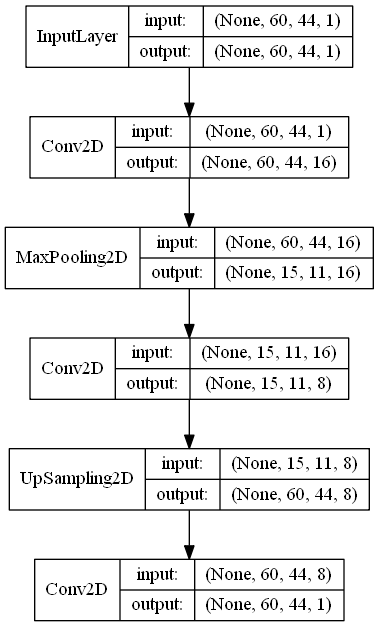

In [40]:
plot_model(autoencoder_ssim, show_shapes=True, show_layer_names=False)

In [29]:
# after running, save keras model with
autoencoder_ssim.save('30iter_SSIM_val20')

In [30]:
# and save history with
import pickle
pickle.dump(history_ssim, open("save_historias_30iter_ssim_val20", "wb" ))

In [55]:
pred_train = autoencoder_ssim.predict(noisytrain) # in sample
pred_test = autoencoder_ssim.predict(noisytest) # out of sample

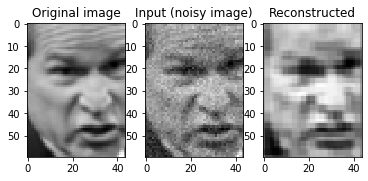

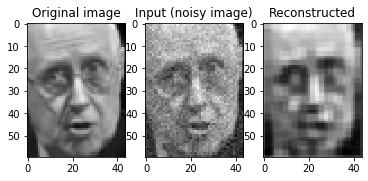

In [56]:
plot_compare(25, teste, noisytest, pred_test) # out of sample prediction
plot_compare(15, treino, noisytrain, pred_train) # in sample prediction - should be better

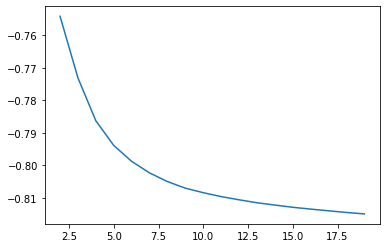

In [43]:
start = 1
finish = 20
y = history_ssim.history['loss'][start:finish]
x = range(start, finish)
sns.lineplot(x, y)

### Calculating MSE(1), in-sample and out-of-sample

In [44]:
mse_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    mse_list_treino[i] = np.mean((pred_train[i] - noisytrain[i])**2)
    
mse_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    mse_list_teste[i] = np.mean((pred_test[i] - noisytest[i])**2)

Text(0.5, 1.0, 'MSE(1) distribution - train/test')

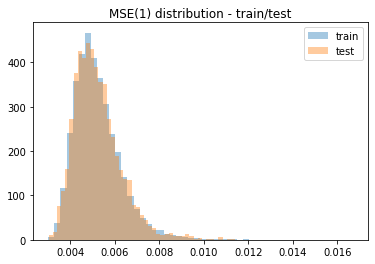

In [46]:
sns.distplot(mse_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(mse_list_teste, label = 'test', norm_hist=True, kde=False)
plt.legend()
plt.title("MSE(1) distribution - train/test")

#plt.xlim(0.0015, 0.0040)

### Calculating MSE(2), in-sample and out-of-sample

In [47]:
mse_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    mse_list_treino[i] = np.mean((pred_train[i] - treino[i])**2)
    
mse_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    mse_list_teste[i] = np.mean((pred_test[i] - teste[i])**2)


Text(0.5, 1.0, 'MSE(2) distribution')

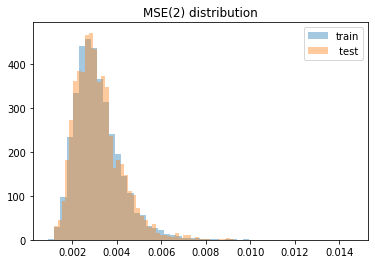

In [48]:
sns.distplot(mse_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(mse_list_teste, label = ' test', norm_hist=True, kde=False)
plt.legend()
plt.title("MSE(2) distribution")

#plt.xlim(0.0015, 0.0040)

### Calculating SSIM(1), in-sample and out-of-sample

In [40]:
from skimage import measure

In [49]:
ssim_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    ssim_list_treino[i] = measure.compare_ssim(noisytrain[i,:,:,0], pred_train[i,:,:,0])
    
ssim_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    ssim_list_teste[i] = measure.compare_ssim(noisytest[i,:,:,0], pred_test[i,:,:,0])

C:\Users\User\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Text(0.5, 1.0, 'SSIM(1) distribution - train/test')

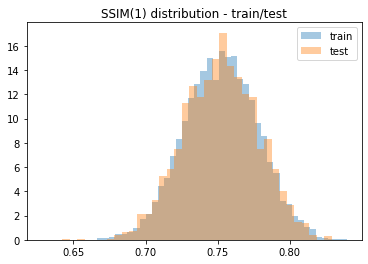

In [50]:
sns.distplot(ssim_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(ssim_list_teste, label = 'test', norm_hist=True, kde=False)
plt.legend()
plt.title("SSIM(1) distribution - train/test")

## Calculating SSIM(2), in-sample and out-of-sample

In [51]:
from skimage import measure

In [52]:
ssim_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    ssim_list_treino[i] = measure.compare_ssim(treino[i,:,:,0], pred_train[i,:,:,0])
    
ssim_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    ssim_list_teste[i] = measure.compare_ssim(teste[i,:,:,0], pred_test[i,:,:,0])

Text(0.5, 1.0, 'SSIM(2) distribution - train/test')

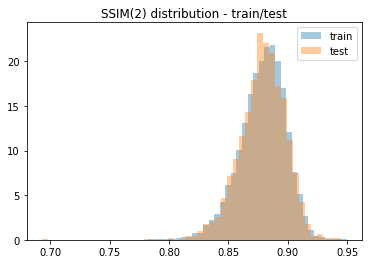

In [54]:
sns.distplot(ssim_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(ssim_list_teste, label = 'test', norm_hist=True, kde=False)
plt.legend()
plt.title("SSIM(2) distribution - train/test")